# Ungraded Lab: Using more sophisticated images with Convolutional Neural Networks

In Course 1 of this specialization, you saw how to use a CNN to make your recognition of computer generated images of horses and humans more efficient. In this lesson, you'll take that to the next level: building a model to classify real images of cats and dogs. Like the horses and humans dataset, real-world images also come in different shapes, aspect ratios, etc. and you will need to take this into account when preparing your data.

In this lab, you will first review how to build CNNs, prepare your data with ImageDataGenerator and examine your results. You'll follow these steps:

1. Explore the example data of Dogs vs. Cats
2. Build and train a neural network to classify between the two pets
3. Evaluate the training and validation accuracy
4. You will build upon your results here in the next labs so you can improve it, particularly in avoiding overfitting. Let's begin!



## Download and Inspect the Dataset

You will start by downloading the dataset. This is a .zip of 2,000 JPG pictures of cats and dogs. It is a subset of the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. You will only use 2,000 of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [2]:
import zipfile
# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [4]:
import os

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [6]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mimg
ncols, nrows = 4, 4
pic_index=0

Display a batch of 8 pics dog  and 8 pics cat.

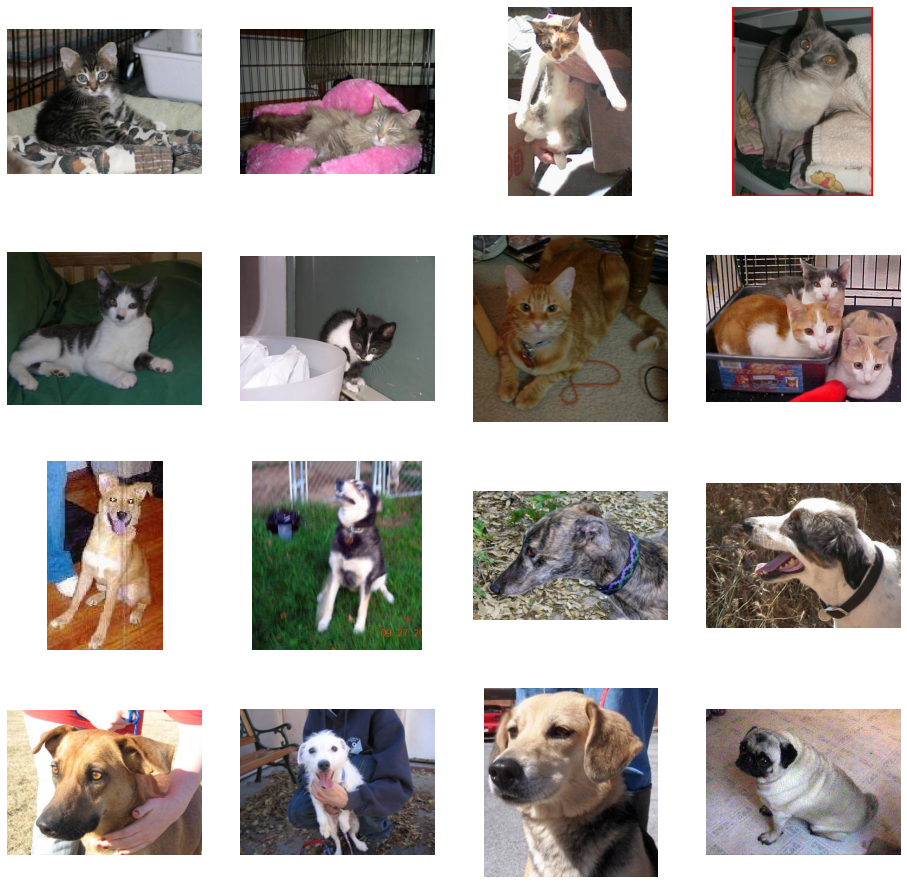

In [13]:
fig=plt.gcf()
fig.set_size_inches(nrows*4,ncols*4)
pic_index+=8

# a list of 8 cat pics
next_cat_pix=[os.path.join(train_cats_dir,fname) for
              fname in train_cat_fnames[pic_index-8:pic_index]]
# a list of 8 dog pics
next_dog_pix=[os.path.join(train_dogs_dir,fname) for
              fname in train_dog_fnames[pic_index-8:pic_index]]

for i,img_path in enumerate(next_cat_pix+next_dog_pix):
    #set up subplot, subplot indices start at 1
    sp=plt.subplot(nrows,ncols,i+1)
    sp.axis('Off')
    img=mimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## Building a Small Model from Scratch to get to ~72% Accuracy

To train a neural network to handle the images, you'll need them to be in a uniform size. You will choose 150x150 pixels for this, and you'll see the code that preprocesses the images to that shape shortly.

You can define the model by importing Tensorflow and using the Keras API. Here is the entire code first then the discussion comes after. This is very similar to the models you have built in Course 1.

In [16]:
import tensorflow as tf
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    # 0 being cat, 1 being dog
    tf.keras.layers.Dense(1,activation='sigmoid')
])

                            

You defined a Sequential layer as before, adding some convolutional layers first. Note the input_shape parameter this time. Here is where you put the 150x150 size and 3 for the color depth because you have colored images. You then add a couple of convolutional layers and flatten the final result to feed into the densely connected layers.

Note that because you are facing a two-class classification problem, i.e. a binary classification problem, you will end the network with a sigmoid activation. The output of the network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

You can review the architecture of the network with the model.summary() method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)       0

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## Data Preprocessing

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training
You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The loss and accuracy are great indicators of progress in training. loss measures the current model prediction against the known labels, calculating the result. accuracy, on the other hand, is the portion of correct guesses.

In [21]:
history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=50,
            verbose=2
            )

Epoch 1/15
100/100 - 24s - loss: 0.5994 - accuracy: 0.6905 - val_loss: 0.6476 - val_accuracy: 0.6050 - 24s/epoch - 244ms/step
Epoch 2/15
100/100 - 26s - loss: 0.5090 - accuracy: 0.7470 - val_loss: 0.5996 - val_accuracy: 0.6850 - 26s/epoch - 260ms/step
Epoch 3/15
100/100 - 24s - loss: 0.4251 - accuracy: 0.8045 - val_loss: 0.7131 - val_accuracy: 0.6830 - 24s/epoch - 240ms/step
Epoch 4/15
100/100 - 24s - loss: 0.3521 - accuracy: 0.8410 - val_loss: 0.6100 - val_accuracy: 0.7080 - 24s/epoch - 237ms/step
Epoch 5/15
100/100 - 24s - loss: 0.2468 - accuracy: 0.8905 - val_loss: 0.8415 - val_accuracy: 0.6930 - 24s/epoch - 237ms/step
Epoch 6/15
100/100 - 24s - loss: 0.1818 - accuracy: 0.9295 - val_loss: 0.9880 - val_accuracy: 0.6990 - 24s/epoch - 236ms/step
Epoch 7/15
100/100 - 24s - loss: 0.1445 - accuracy: 0.9420 - val_loss: 1.1135 - val_accuracy: 0.7080 - 24s/epoch - 237ms/step
Epoch 8/15
100/100 - 24s - loss: 0.0995 - accuracy: 0.9670 - val_loss: 1.3251 - val_accuracy: 0.7160 - 24s/epoch - 238

In [29]:
from ipywidgets import FileUpload
upload=FileUpload(multiple=True)
display(upload)

FileUpload(value={}, description='Upload', multiple=True)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
for fn in upload.value.keys():
    path=os.path.join('./image/',fn)
    img=image.load_img(path,target_size=(150,150))
    x=image.img_to_array(img)
    x/=255
    x=np.expand_dims(x,axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    
    if classes[0]>0.5:
        print(fn + " is a dog")
        
    else:
        print(fn + " is a cat")
    

[1.8583915e-18]
cat.206.jpg is a cat


Text(0.5, 1.0, 'Training and validation loss')

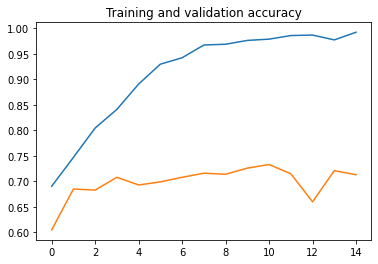

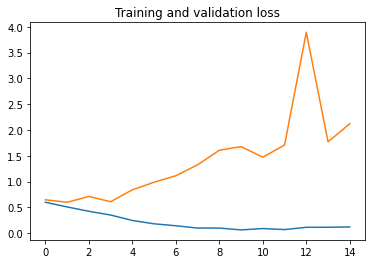

In [38]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )